In [9]:
# ============================================
# 0. IMPORT & INSTALL LIBRARIES
# ============================================
# Install libraries
!python -m spacy download en_core_web_sm --quiet
!pip install -q sentence-transformers scikit-learn xgboost
!pip install pdfplumber python-docx spacy --quiet

# --- general ---
import pandas as pd
import numpy as np
import os
import re
import glob
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

# --- import for part 3 ---
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # for saving models

# --- import for part 4 ---
from google.colab import files
import pdfplumber
import docx

# --- import for part 6: question generation ---
import kagglehub
from kagglehub import KaggleDatasetAdapter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
# ============================================
# ADDITIONAL FUNCTION: extract_technical_skills_from_skill2vec
# Fix cho error "function not defined"
# ============================================

def extract_technical_skills_from_skill2vec():
    """
    Alternative approach: Extract technical skills directly from skill2vec data
    """
    try:
        print("Alternative extraction from skill2vec data...")

        # Load skill2vec data
        url = "https://raw.githubusercontent.com/duyet/skill2vec-dataset/master/skill2vec_10K.csv"
        df_skills = pd.read_csv(url, header=None, low_memory=False).iloc[:, 1:]

        print(f"Processing skill2vec data: {df_skills.shape}")

        # Find technical skills from technical CVs
        technical_skills = set()
        technical_cvs_found = 0

        for idx in range(min(200, len(df_skills))):
            row_skills = df_skills.iloc[idx].dropna().tolist()
            row_text = ' '.join(str(skill).lower() for skill in row_skills)

            # Check if row has technical content
            tech_indicators = [
                'programming', 'development', 'software', 'web', 'database',
                'python', 'java', 'javascript', 'sql', 'html', 'css',
                'react', 'angular', 'node', 'api', 'framework', 'git', 'linux'
            ]

            tech_score = sum(1 for indicator in tech_indicators if indicator in row_text)

            if tech_score >= 3:  # This is a technical CV
                technical_cvs_found += 1

                for skill in row_skills:
                    skill_clean = str(skill).strip().lower()

                    # Basic validation
                    if (len(skill_clean) > 1 and len(skill_clean) < 30 and
                        not any(noise in skill_clean for noise in [
                            'training', 'management', 'experience', 'university',
                            'company', 'years', 'level', 'senior', 'junior',
                            'manager', 'analyst', 'director', 'coordinator'
                        ])):
                        technical_skills.add(skill_clean)

        print(f"Found {technical_cvs_found} technical CVs")
        print(f"Extracted {len(technical_skills)} potential technical skills")

        # Filter to definitely technical skills only
        definitely_technical = {
            'python', 'java', 'javascript', 'typescript', 'react', 'angular', 'vue',
            'html', 'css', 'sql', 'mysql', 'postgresql', 'mongodb', 'redis',
            'aws', 'azure', 'docker', 'kubernetes', 'git', 'linux', 'node',
            'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy',
            'bootstrap', 'jquery', 'webpack', 'elasticsearch', 'microservices',
            'django', 'flask', 'spring', 'laravel', 'rails', 'express',
            'cassandra', 'neo4j', 'jenkins', 'terraform', 'ansible',
            'graphql', 'restful', 'oauth', 'jwt', 'ssl', 'api'
        }

        validated_skills = [skill for skill in technical_skills if skill in definitely_technical]

        print(f"Validated technical skills: {len(validated_skills)}")
        print(f"Sample validated skills: {sorted(validated_skills)[:10]}")

        return validated_skills

    except Exception as e:
        print(f"Alternative extraction error: {e}")
        return []

# Test the function
print("Testing extract_technical_skills_from_skill2vec()...")
test_result = extract_technical_skills_from_skill2vec()
print(f"Function working! Found {len(test_result)} technical skills")

print("\nFunction extract_technical_skills_from_skill2vec() successfully added to notebook!")


Testing extract_technical_skills_from_skill2vec()...
Alternative extraction from skill2vec data...
Processing skill2vec data: (10000, 960)
Found 21 technical CVs
Extracted 352 potential technical skills
Validated technical skills: 16
Sample validated skills: ['cassandra', 'css', 'docker', 'elasticsearch', 'git', 'html', 'java', 'javascript', 'jquery', 'linux']
Function working! Found 16 technical skills

Function extract_technical_skills_from_skill2vec() successfully added to notebook!


In [11]:
# ============================================
# 1. REPARE CV DATA FOR TRAINING REASON
# ============================================
import pandas as pd
import numpy as np
import re
import nltk
import spacy

# Download NLTK resources
for pkg in ['punkt', 'punkt_tab', 'stopwords']:
    nltk.download(pkg, quiet=True)
from nltk.corpus import stopwords

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Import additional libraries for NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
from pathlib import Path
import joblib
import json

def read_dataset_csv(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
    return df

# ============================================
# ENHANCED SKILL EXTRACTOR CLASS
# ============================================

class EnhancedNLPSkillExtractor:
    """
    Hệ thống NLP đã được train từ labeled job data
    Sử dụng TF-IDF similarity cho skill extraction
    """

    def __init__(self):
        self.skill_database = set()
        self.vectorizer = None
        self.skill_vectors = None
        self.skill_names = []
        self.trained = False

        print("Initializing Enhanced NLP Skill Extractor...")
        self._load_or_train_models()

    def _load_or_train_models(self):
        """Load trained models hoặc train nếu chưa có"""
        try:
            # Try load existing models (COLAB PATHS)
            self.vectorizer = joblib.load('./content/fast_models/tfidf_vectorizer.pkl')
            self.skill_vectors = joblib.load('./content/fast_models/skill_vectors.pkl')
            self.skill_names = joblib.load('./content/fast_models/skill_names.pkl')
            self.trained = True
            print(f"Loaded trained models: {len(self.skill_names)} skills")
        except:
            print("No trained models found, training from labeled data...")
            self._train_from_labeled_data()

    def _train_from_labeled_data(self):
        """Train models từ labeled datasets"""
        try:
            # Load labeled datasets (COLAB PATHS)
            df1 = pd.read_csv('./data/all_job_post.csv')
            df2 = pd.read_csv('./data/JobsDatasetProcessed.csv')

            print(f"Training from {df1.shape[0]} + {df2.shape[0]} labeled examples")

            # Build skill knowledge base
            skill_contexts = defaultdict(list)

            # Process dataset 1
            for idx, row in df1.iterrows():
                if pd.notna(row['job_description']) and pd.notna(row['job_skill_set']):
                    text = str(row['job_description'])
                    skills = self._parse_skills(row['job_skill_set'])

                    for skill in skills:
                        if self._is_technical_skill(skill):
                            skill_contexts[skill].append(text)

            # Process dataset 2
            for idx, row in df2.iterrows():
                if pd.notna(row['Description']) and pd.notna(row['IT Skills']):
                    text = str(row['Description'])
                    skills = self._parse_skills(row['IT Skills'])

                    for skill in skills:
                        if self._is_technical_skill(skill):
                            skill_contexts[skill].append(text)

            # Filter skills với enough contexts
            filtered_contexts = {skill: contexts for skill, contexts in skill_contexts.items()
                               if len(contexts) >= 3}

            print(f"Training TF-IDF model on {len(filtered_contexts)} skills")

            # Train TF-IDF model
            skill_docs = []
            skill_names = []

            for skill, contexts in filtered_contexts.items():
                combined_context = ' '.join(contexts[:10])  # Max 10 contexts
                skill_docs.append(combined_context)
                skill_names.append(skill)

            # TF-IDF vectorization
            vectorizer = TfidfVectorizer(
                max_features=3000,
                ngram_range=(1, 3),
                stop_words='english',
                lowercase=True,
                min_df=1
            )

            skill_vectors = vectorizer.fit_transform(skill_docs)

            # Save models (COLAB PATHS)
            Path('/content/fast_models').mkdir(exist_ok=True)
            joblib.dump(vectorizer, '/content/fast_models/tfidf_vectorizer.pkl')
            joblib.dump(skill_vectors, '/content/fast_models/skill_vectors.pkl')
            joblib.dump(skill_names, '/content/fast_models/skill_names.pkl')

            self.vectorizer = vectorizer
            self.skill_vectors = skill_vectors
            self.skill_names = skill_names
            self.trained = True

            print(f"Training completed: {len(skill_names)} skills")

        except Exception as e:
            print(f"Training failed: {e}")
            self.trained = False

    def _parse_skills(self, skill_string):
        """Parse skill string"""
        if pd.isna(skill_string):
            return []

        skill_string = str(skill_string)
        skill_string = re.sub(r'[\'"\[\]]', '', skill_string)
        skills = re.split(r'[,;|]|\sand\s', skill_string)

        cleaned = []
        for skill in skills:
            skill = skill.strip()
            skill = re.sub(r'\([^)]*\)', '', skill)
            skill = skill.strip()

            if len(skill) > 1:
                cleaned.append(skill.lower())

        return cleaned

    def _is_technical_skill(self, skill):
        """Check if skill is technical"""
        skill_lower = skill.lower()

        # Exclude soft skills
        soft_skills = {
            'communication', 'teamwork', 'leadership', 'problem solving',
            'time management', 'adaptability', 'collaboration'
        }

        if skill_lower in soft_skills:
            return False

        # Include technical indicators
        tech_keywords = {
            'programming', 'development', 'database', 'cloud', 'framework',
            'python', 'java', 'javascript', 'sql', 'aws', 'docker', 'react'
        }

        return any(keyword in skill_lower for keyword in tech_keywords) or len(skill_lower.split()) <= 2

    def extract_skills(self, text, top_k=15, threshold=0.15):
        """Extract skills using trained TF-IDF similarity"""
        if not self.trained:
            return []

        try:
            # Vectorize input text
            text_clean = str(text).lower()
            text_vector = self.vectorizer.transform([text_clean])

            # Calculate similarities
            similarities = cosine_similarity(text_vector, self.skill_vectors)[0]

            # Get top similar skills
            top_indices = np.argsort(similarities)[::-1][:top_k]

            predicted_skills = []
            for idx in top_indices:
                similarity = similarities[idx]
                if similarity >= threshold:
                    skill = self.skill_names[idx]
                    predicted_skills.append(skill)

            return predicted_skills

        except Exception as e:
            print(f"Error in skill extraction: {e}")
            return []

# Initialize enhanced extractor (chỉ chạy 1 lần)
print("Initializing Enhanced NLP Skill Extractor...")
enhanced_nlp_extractor = EnhancedNLPSkillExtractor()

# ============================================
# ORIGINAL SKILL LIST (Keep for compatibility)
# ============================================
SKILL_LIST = {
    "data structures", "algorithms", "python", "java", "c++", "c#", "rust",
    "javascript", "typescript", "html", "css", "php", "ruby", "go", "swift",
    "git", "version control", "testing", "unit testing", "database",
    "mysql", "postgresql", "mongodb", "cloud computing", "aws", "azure",
    "docker", "kubernetes", "ci/cd", "devops", "machine learning",
    "deep learning", "nlp", "cybersecurity", "web development",
    "mobile development", "android", "ios", "data analysis", "sql",
    "problem solving", "linux", "shell scripting"
}

# ============================================
# SKILL2VEC INTEGRATION - Apply trained models to unlabeled data
# Sử dụng trained NLP models để mở rộng SKILL_LIST từ skill2vec data
# ============================================

def clean_skill(s):
    """Enhanced clean skill function for skill2vec data"""
    if not s or pd.isna(s):
        return None

    s = str(s).strip().lower()

    # Bỏ rỗng
    if not s:
        return None

    # Remove HTML entities và special characters
    s = re.sub(r'&quot;|"|&|<|>', '', s)
    s = re.sub(r'[^\w\s\.\-\+#]', ' ', s)  # Keep only alphanumeric, space, dot, dash, plus, hash
    s = re.sub(r'\s+', ' ', s).strip()  # Multiple spaces to single

    # Bỏ nếu quá dài (likely spam/noise)
    if len(s) > 50:
        return None

    # Bỏ nếu chứa quá nhiều keywords (spam detection)
    spam_indicators = s.count(' or ') + s.count(' and ') + s.count('quot')
    if spam_indicators > 3:
        return None

    # Bỏ job titles và non-technical terms
    job_titles = {
        'manager', 'analyst', 'director', 'coordinator', 'specialist',
        'officer', 'assistant', 'supervisor', 'lead', 'senior',
        'junior', 'intern', 'consultant', 'advisor', 'executive'
    }

    # Check if it's primarily a job title
    words = s.split()
    if len(words) <= 3 and any(title in s for title in job_titles):
        # Keep only if it has technical context
        tech_context = any(tech in s for tech in [
            'software', 'system', 'data', 'network', 'security', 'cloud',
            'web', 'mobile', 'database', 'api', 'development', 'engineering'
        ])
        if not tech_context:
            return None

    # Giữ đặc biệt C, R, Go, .net
    special_keep = {'c', 'r', 'go', '.net', 'c++', 'c#', 'f#'}
    if s in special_keep:
        return s

    # Bỏ số hoặc chỉ ký hiệu
    if re.fullmatch(r"[\d\.\-\+]+", s):
        return None

    # Bỏ từ 1 ký tự (trừ special cases)
    if len(s) < 2:
        return None

    # Bỏ stopwords mở rộng
    stopwords = {
        "and", "or", "to", "of", "in", "on", "at", "for", "with", "by",
        "the", "a", "an", "is", "are", "was", "were", "be", "been", "being",
        "have", "has", "had", "do", "does", "did", "will", "would", "could",
        "should", "may", "might", "must", "can", "this", "that", "these", "those"
    }

    if s in stopwords:
        return None

    # Bỏ nếu chứa suspicious patterns
    suspicious_patterns = [
        r'^\d+[a-z]*$',     # Numbers with letters: 3gpp, 2d, 3d
        r'_[a-z]',          # Underscore patterns: advertsing_campaign
        r'maintenance$',    # Maintenance jobs
        r'rendering$',      # Non-programming rendering
        r'mobiles?$',       # Mobile devices/brands
        r'campaign',        # Marketing campaigns
        r'verification$',   # Testing/QA (unless software testing)
        r'^adobe',          # Adobe products (unless technical)
        r'^alcatel|^nokia|^samsung|^apple', # Device brands
    ]

    # Special exceptions for technical terms
    tech_exceptions = [
        'software verification', 'code verification', 'system verification',
        'adobe flash', 'adobe air', 'mobile development', 'mobile app'
    ]

    # Check suspicious patterns but allow technical exceptions
    is_suspicious = any(re.search(pattern, s) for pattern in suspicious_patterns)
    is_exception = any(exception in s for exception in tech_exceptions)

    if is_suspicious and not is_exception:
        return None

    # Additional filters for common noise
    noise_terms = {
        'services', 'solutions', 'systems', 'lab', 'laboratory',
        'center', 'centre', 'office', 'department', 'division',
        'group', 'team', 'unit', 'branch', 'facility'
    }

    # If it's just a generic term, filter it out
    if len(words) <= 2 and any(noise in s for noise in noise_terms):
        # Keep only if it has technical context
        tech_indicators = [
            'software', 'web', 'mobile', 'data', 'cloud', 'network',
            'security', 'database', 'api', 'development', 'programming'
        ]
        if not any(tech in s for tech in tech_indicators):
            return None

    return s

def validate_skill_with_trained_model(skill_candidate, context=""):
    """
    Enhanced validation using trained NLP model + additional filters
    """
    if not enhanced_nlp_extractor.trained:
        return False

    skill_lower = skill_candidate.lower().strip()

    # Pre-validation filters
    if not _is_technical_skill_candidate(skill_lower):
        return False

    # Create test context for skill
    test_text = f"Experience with {skill_candidate} development and {skill_candidate} programming"

    # Use trained model để check if skill is valid
    try:
        extracted_skills = enhanced_nlp_extractor.extract_skills(test_text, threshold=0.1)

        # Check if similar skills are found
        for extracted in extracted_skills:
            if (skill_candidate.lower() in extracted.lower() or
                extracted.lower() in skill_candidate.lower()):
                return True

        # Check against known technical patterns
        tech_patterns = [
            r'\w+script', r'\w+\.js', r'\w+\.py', r'\w+\+\+',
            r'machine learning', r'data science', r'web development',
            r'software', r'programming', r'development', r'framework',
            r'database', r'server', r'cloud', r'api', r'sdk'
        ]

        pattern_match = any(re.search(pattern, skill_lower) for pattern in tech_patterns)

        # Additional validation for common technical skills
        known_technical = {
            'python', 'java', 'javascript', 'typescript', 'react', 'angular', 'vue',
            'node', 'express', 'django', 'flask', 'spring', 'laravel',
            'sql', 'mysql', 'postgresql', 'mongodb', 'redis', 'elasticsearch',
            'docker', 'kubernetes', 'aws', 'azure', 'gcp', 'terraform',
            'git', 'jenkins', 'ci/cd', 'devops', 'linux', 'windows',
            'html', 'css', 'sass', 'bootstrap', 'jquery', 'webpack',
            'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy'
        }

        direct_match = skill_lower in known_technical

        return pattern_match or direct_match

    except:
        return False

def _is_technical_skill_candidate(skill):
    """Additional pre-filtering for technical skills"""

    # Exclude obvious non-technical terms
    non_technical_terms = {
        'advertising', 'marketing', 'sales', 'finance', 'accounting',
        'human resources', 'hr', 'recruiting', 'legal', 'compliance',
        'administration', 'office', 'clerical', 'customer service',
        'retail', 'hospitality', 'food service', 'healthcare',
        'nursing', 'medical', 'pharmacy', 'dental', 'veterinary',
        'education', 'teaching', 'training', 'coaching', 'mentoring',
        'real estate', 'insurance', 'banking', 'investment',
        'logistics', 'transportation', 'shipping', 'warehouse',
        'manufacturing', 'production', 'quality control', 'assembly'
    }

    # Check if skill contains non-technical terms
    if any(term in skill for term in non_technical_terms):
        return False

    # Exclude pure job titles without technical context
    job_title_only = [
        'manager', 'director', 'coordinator', 'specialist', 'analyst',
        'officer', 'assistant', 'supervisor', 'lead', 'consultant'
    ]

    words = skill.split()
    if len(words) <= 2 and any(title in skill for title in job_title_only):
        return False

    # Exclude industry-specific non-tech terms
    industry_terms = {
        'aircraft', 'automotive', 'construction', 'agriculture',
        'textiles', 'fashion', 'beauty', 'cosmetics', 'jewelry',
        'sports', 'fitness', 'entertainment', 'media', 'publishing',
        'photography', 'video production', 'graphic design'
    }

    if any(term in skill for term in industry_terms):
        return False

    return True

def apply_trained_models_to_skill2vec():
    """
    ĐÚNG MỤC ĐÍCH: Sử dụng trained models để extract skills từ skill2vec (unlabeled data)
    """
    try:
        print("APPLYING TRAINED MODELS TO SKILL2VEC (UNLABELED DATA)")
        print("=" * 60)

        # Load skill2vec data (raw, unlabeled)
        url = "https://raw.githubusercontent.com/duyet/skill2vec-dataset/master/skill2vec_10K.csv"
        df_skills = pd.read_csv(url, header=None, low_memory=False).iloc[:, 1:]

        print(f"Skill2vec raw data: {df_skills.shape}")
        print("Goal: Use trained NLP models to extract skills from this unlabeled data")

        if not enhanced_nlp_extractor.trained:
            print("❌ No trained models available! Please train first from labeled data.")
            return []

        # Process skill2vec CVs using trained models
        extracted_skills_from_unlabeled = set()
        processed_cvs = 0

        print("🤖 Applying trained models to extract skills from unlabeled CVs...")

        # Process each CV in skill2vec dataset
        for idx in range(min(200, len(df_skills))):  # Process first 200 CVs
            # Get all skills/text for this CV
            cv_skills = df_skills.iloc[idx].dropna().tolist()
            cv_text = ' '.join(str(skill) for skill in cv_skills)

            # Skip if CV is too short or looks non-technical
            if len(cv_text) < 50:
                continue

            # Use trained NLP model to extract skills from this unlabeled CV
            try:
                # Apply trained model to this unlabeled text
                predicted_skills = enhanced_nlp_extractor.extract_skills(
                    cv_text,
                    top_k=20,
                    threshold=0.2  # Lower threshold for discovery
                )

                # Add discovered skills to our database
                for skill in predicted_skills:
                    if len(skill) > 1 and len(skill) < 30:  # Basic validation
                        extracted_skills_from_unlabeled.add(skill)

                processed_cvs += 1

                # Progress indicator
                if processed_cvs % 20 == 0:
                    print(f"   Processed {processed_cvs} CVs, discovered {len(extracted_skills_from_unlabeled)} unique skills")

            except Exception as e:
                continue

        print(f"TRANSFER LEARNING RESULTS:")
        print(f"   - Processed {processed_cvs} unlabeled CVs from skill2vec")
        print(f"   - Discovered {len(extracted_skills_from_unlabeled)} new skills using trained models")

        # Clean discovered skills
        final_discovered_skills = []
        for skill in extracted_skills_from_unlabeled:
            # Apply basic cleaning
            cleaned = clean_skill(skill)
            if cleaned and is_valuable_discovered_skill(cleaned):
                final_discovered_skills.append(cleaned)

        print(f"Final discovered skills after cleaning: {len(final_discovered_skills)}")

        # Show sample discovered skills
        print(f"Sample skills discovered from unlabeled data:")
        for skill in sorted(final_discovered_skills)[:20]:
            print(f"   • {skill}")

        return final_discovered_skills

    except Exception as e:
        print(f"Error applying models to skill2vec: {e}")
        return []

def is_valuable_discovered_skill(skill):
    """
    Check if discovered skill adds value to our database
    """
    skill_lower = skill.lower()

    # Skip if already in original SKILL_LIST
    original_static_skills = {
        "data structures", "algorithms", "python", "java", "c++", "c#", "rust",
        "javascript", "typescript", "html", "css", "php", "ruby", "go", "swift",
        "git", "version control", "testing", "unit testing", "database",
        "mysql", "postgresql", "mongodb", "cloud computing", "aws", "azure",
        "docker", "kubernetes", "ci/cd", "devops", "machine learning",
        "deep learning", "nlp", "cybersecurity", "web development",
        "mobile development", "android", "ios", "data analysis", "sql",
        "problem solving", "linux", "shell scripting"
    }

    if skill_lower in original_static_skills:
        return False  # Already have this

    # Only keep if it's clearly technical and adds value
    valuable_patterns = [
        r'.*framework.*', r'.*library.*', r'.*sdk.*', r'.*api.*',
        r'.*server.*', r'.*database.*', r'.*platform.*', r'.*service.*',
        r'.*development.*', r'.*programming.*', r'.*scripting.*'
    ]

    # Known valuable technical skills not in original list
    valuable_additions = {
        'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy', 'matplotlib',
        'react', 'angular', 'vue', 'node', 'express', 'django', 'flask',
        'spring', 'laravel', 'rails', 'bootstrap', 'jquery', 'webpack',
        'redis', 'elasticsearch', 'cassandra', 'neo4j', 'jenkins', 'terraform',
        'ansible', 'puppet', 'helm', 'grafana', 'prometheus', 'elk',
        'microservices', 'restful', 'graphql', 'oauth', 'jwt', 'ssl'
    }

    return (skill_lower in valuable_additions or
            any(re.search(pattern, skill_lower) for pattern in valuable_patterns))

# Apply trained models to skill2vec (correct approach)
try:
    skill2vec_discovered = apply_trained_models_to_skill2vec()
except Exception as e:
    print(f"Error in transfer learning: {e}")
    skill2vec_discovered = []  # Empty fallback

def clean_skill_strict(s):
    """
    Stricter cleaning for skill2vec data
    """
    if not s or pd.isna(s):
        return None

    s = str(s).strip().lower()
    if not s:
        return None

    # Remove HTML entities và special characters
    s = re.sub(r'&quot;|"|&|<|>', '', s)
    s = re.sub(r'[^\w\s\.\-\+#]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()

    # Basic length check
    if len(s) < 2 or len(s) > 30:  # Stricter length limit
        return None

    # Immediate rejection patterns
    reject_patterns = [
        r'^\d+[a-z]*$',        # 3gpp, 2d, 3d
        r'.*_.*',              # Underscore patterns
        r'.*training.*',       # Training-related
        r'.*management.*',     # Management-related
        r'.*experience.*',     # Experience-related
        r'.*ambulance.*',      # Medical
        r'.*anaesth.*',        # Medical
        r'.*american.*',       # Company names
        r'.*university.*',     # Education
        r'.*clinic.*',         # Medical
        r'.*nursing.*',        # Medical
        r'.*airline.*',        # Aviation
        r'.*voice.*',          # Call center
        r'.*accent.*',         # Call center
        r'.*bpo.*',            # Business process
        r'.*call centre.*',    # Call center
    ]

    if any(re.search(pattern, s) for pattern in reject_patterns):
        return None

    # Keep special programming languages
    special_keep = {'c', 'r', 'go', '.net', 'c++', 'c#', 'f#'}
    if s in special_keep:
        return s

    return s

def is_definitely_technical_skill(skill):
    """
    Final validation - only keep definitely technical skills
    """
    skill_lower = skill.lower()

    # Definite technical skills (whitelist approach)
    definite_technical = {
        # Programming languages
        'python', 'java', 'javascript', 'typescript', 'c++', 'c#', 'go', 'rust',
        'swift', 'kotlin', 'scala', 'ruby', 'php', 'perl', 'r', 'c', 'dart',
        'objective-c', 'assembly', 'cobol', 'fortran', 'haskell', 'lua', 'matlab',

        # Web technologies
        'html', 'css', 'react', 'angular', 'vue', 'node', 'express', 'django',
        'flask', 'spring', 'laravel', 'rails', 'asp.net', 'jquery', 'bootstrap',

        # Databases
        'sql', 'mysql', 'postgresql', 'mongodb', 'redis', 'elasticsearch',
        'oracle', 'sqlite', 'cassandra', 'dynamodb', 'neo4j',

        # Cloud & DevOps
        'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 'terraform',
        'ansible', 'puppet', 'chef', 'vagrant', 'helm', 'git', 'github', 'gitlab',

        # Operating Systems
        'linux', 'ubuntu', 'centos', 'windows', 'macos', 'unix', 'debian',

        # Tools & IDEs
        'vscode', 'intellij', 'eclipse', 'visual studio', 'sublime', 'atom',
        'vim', 'emacs', 'nano', 'notepad++',

        # Testing
        'selenium', 'junit', 'pytest', 'jest', 'mocha', 'cypress',

        # ML & AI
        'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy',
        'matplotlib', 'opencv', 'nltk', 'spacy', 'keras',

        # Mobile
        'android', 'ios', 'react native', 'flutter', 'xamarin', 'ionic',

        # Build tools
        'webpack', 'babel', 'gulp', 'grunt', 'maven', 'gradle', 'npm', 'yarn'
    }

    # Exact match
    if skill_lower in definite_technical:
        return True

    # Technical patterns (be very selective)
    technical_patterns = [
        r'^.*script$',          # JavaScript, TypeScript, etc.
        r'^.*\.js$',            # React.js, Vue.js, etc.
        r'^.*\.py$',            # Django.py, etc.
        r'^.*\+\+$',            # C++, etc.
        r'^.*framework$',       # Angular framework, etc.
        r'^.*api$',             # REST API, etc.
        r'^.*sdk$',             # Android SDK, etc.
        r'^.*server$',          # Apache server, etc.
        r'^.*database$',        # MySQL database, etc.
    ]

    # Must be short and match technical pattern
    if len(skill_lower.split()) <= 2:
        return any(re.match(pattern, skill_lower) for pattern in technical_patterns)

    return False

# Apply smart extraction
try:
    skill2vec_validated = extract_technical_skills_from_skill2vec()
except Exception as e:
    print(f"Error in smart extraction: {e}")
    skill2vec_validated = ["python", "java", "sql", "git", "javascript"]  # fallback

# ============================================
# TRANSFER LEARNING: Merge discovered skills với original SKILL_LIST
# ============================================

print("🔗 TRANSFER LEARNING - Merging discovered skills with original SKILL_LIST...")
print("=" * 70)

print(f"📊 SKILL SOURCES:")
print(f"   1. Original static skills: 43")
print(f"   2. Trained NLP model skills: {len(enhanced_nlp_extractor.skill_names) if enhanced_nlp_extractor.trained else 0}")
print(f"   3. Discovered from skill2vec (unlabeled): {len(skill2vec_discovered)}")

# Combine all skill sources
original_static = {
    "data structures", "algorithms", "python", "java", "c++", "c#", "rust",
    "javascript", "typescript", "html", "css", "php", "ruby", "go", "swift",
    "git", "version control", "testing", "unit testing", "database",
    "mysql", "postgresql", "mongodb", "cloud computing", "aws", "azure",
    "docker", "kubernetes", "ci/cd", "devops", "machine learning",
    "deep learning", "nlp", "cybersecurity", "web development",
    "mobile development", "android", "ios", "data analysis", "sql",
    "problem solving", "linux", "shell scripting"
}

# Merge: Original + Discovered from unlabeled data
SKILL_LIST = original_static.union(set(skill2vec_discovered))

print(f"\nFINAL SKILL_LIST COMPOSITION:")
print(f"   - Original static skills: {len(original_static)}")
print(f"   - Skills discovered from unlabeled data: {len(skill2vec_discovered)}")
print(f"   - Total unique skills: {len(SKILL_LIST)}")
print(f"   - Net addition: {len(SKILL_LIST) - len(original_static)} new skills")

# Show new skills discovered through transfer learning
new_discovered_skills = set(skill2vec_discovered) - original_static

if new_discovered_skills:
    print(f"\nNEW SKILLS DISCOVERED FROM UNLABELED DATA (Transfer Learning):")
    for skill in sorted(list(new_discovered_skills))[:20]:
        print(f"   • {skill}")

    if len(new_discovered_skills) > 20:
        print(f"   ... and {len(new_discovered_skills) - 20} more")
else:
    print(f"\nNo new skills discovered (all predicted skills were already in original list)")

print(f"\n🎓 NLP APPROACH SUMMARY:")
print(f"   1. Supervised Learning: Train từ {len(enhanced_nlp_extractor.skill_names) if enhanced_nlp_extractor.trained else 0} labeled examples")
print(f"   2. Transfer Learning: Apply trained models to unlabeled skill2vec data")
print(f"   3. Knowledge Discovery: Found {len(new_discovered_skills)} new technical skills")
print(f"   4. Database Expansion: {len(original_static)} → {len(SKILL_LIST)} skills")

print(f"\n Enhanced NLP system ready!")
print(f"SKILL_LIST now contains both original + discovered skills from unlabeled data!")

for S in sorted(list(SKILL_LIST))[:1000]:
    print(f"   • {S}")

Initializing Enhanced NLP Skill Extractor...
Initializing Enhanced NLP Skill Extractor...
No trained models found, training from labeled data...
Training from 1167 + 3000 labeled examples
Training TF-IDF model on 2364 skills
Training completed: 2364 skills
APPLYING TRAINED MODELS TO SKILL2VEC (UNLABELED DATA)
Skill2vec raw data: (10000, 960)
Goal: Use trained NLP models to extract skills from this unlabeled data
🤖 Applying trained models to extract skills from unlabeled CVs...
   Processed 20 CVs, discovered 183 unique skills
   Processed 40 CVs, discovered 350 unique skills
   Processed 60 CVs, discovered 432 unique skills
   Processed 80 CVs, discovered 487 unique skills
   Processed 100 CVs, discovered 566 unique skills
   Processed 120 CVs, discovered 656 unique skills
   Processed 140 CVs, discovered 730 unique skills
   Processed 160 CVs, discovered 813 unique skills
TRANSFER LEARNING RESULTS:
   - Processed 168 unlabeled CVs from skill2vec
   - Discovered 820 new skills using tr

In [12]:
# ============================================
# INSPECT SKILL_LIST - Xem tất cả skills có trong database
# ============================================

print("SKILL_LIST INSPECTION")
print("=" * 50)

# Basic stats
print(f"SKILL DATABASE STATISTICS:")
print(f" Total skills: {len(SKILL_LIST)}")
print(f" Data type: {type(SKILL_LIST)}")

# Convert to sorted list for easier viewing
skill_list_sorted = sorted(list(SKILL_LIST))

print(f"\nALL SKILLS IN DATABASE ({len(skill_list_sorted)} total):")
print("-" * 50)

# Display skills in numbered list
for i, skill in enumerate(skill_list_sorted, 1):
    print(f"{i:3d}. {skill}")

    # Add separator every 20 skills for readability
    if i % 20 == 0:
        print()

# Categorize skills by type
print(f"\nSKILL CATEGORIES:")
print("-" * 30)

# Programming languages
programming_langs = [s for s in SKILL_LIST if any(lang in s.lower() for lang in [
    'python', 'java', 'javascript', 'typescript', 'c++', 'c#', 'go', 'rust',
    'swift', 'kotlin', 'scala', 'ruby', 'php', 'perl', 'r '
])]

# Databases
databases = [s for s in SKILL_LIST if any(db in s.lower() for db in [
    'sql', 'mysql', 'postgresql', 'mongodb', 'redis', 'elasticsearch',
    'database', 'oracle', 'sqlite'
])]

# Cloud & DevOps
cloud_devops = [s for s in SKILL_LIST if any(cloud in s.lower() for cloud in [
    'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'jenkins', 'terraform',
    'devops', 'ci/cd', 'cloud'
])]

# Web Technologies
web_tech = [s for s in SKILL_LIST if any(web in s.lower() for web in [
    'html', 'css', 'react', 'angular', 'vue', 'node', 'express', 'django',
    'flask', 'spring', 'web', 'api', 'rest'
])]

# Machine Learning & AI
ml_ai = [s for s in SKILL_LIST if any(ml in s.lower() for ml in [
    'machine learning', 'deep learning', 'tensorflow', 'pytorch', 'scikit',
    'pandas', 'numpy', 'ai', 'artificial intelligence', 'neural', 'nlp'
])]

print(f"Programming Languages ({len(programming_langs)}):")
for lang in sorted(programming_langs)[:10]:
    print(f"   • {lang}")

print(f"\nDatabases ({len(databases)}):")
for db in sorted(databases)[:10]:
    print(f"   • {db}")

print(f"\nCloud & DevOps ({len(cloud_devops)}):")
for cloud in sorted(cloud_devops)[:10]:
    print(f"   • {cloud}")

print(f"\nWeb Technologies ({len(web_tech)}):")
for web in sorted(web_tech)[:10]:
    print(f"   • {web}")

print(f"\nML & AI ({len(ml_ai)}):")
for ml in sorted(ml_ai)[:10]:
    print(f"   • {ml}")

# Search functionality
print(f"\nSEARCH FUNCTIONALITY:")
print("To search for specific skills, use:")
print("search_term = 'python'")
print("matching_skills = [s for s in SKILL_LIST if search_term.lower() in s.lower()]")
print("print(f'Skills containing \"{search_term}\": {matching_skills}')")

# Sample searches
sample_searches = ['python', 'web', 'data', 'cloud', 'machine']
print(f"\nSAMPLE SEARCHES:")
for term in sample_searches:
    matches = [s for s in SKILL_LIST if term.lower() in s.lower()]
    print(f"   '{term}': {len(matches)} matches - {matches[:3]}...")

print(f"\nSKILL_LIST inspection completed!")
print(f"📋 Total: {len(SKILL_LIST)} skills available for CV matching")

SKILL_LIST INSPECTION
SKILL DATABASE STATISTICS:
 Total skills: 134
 Data type: <class 'set'>

ALL SKILLS IN DATABASE (134 total):
--------------------------------------------------
  1. agile development
  2. agile software development
  3. algorithms
  4. android
  5. api management
  6. application development
  7. automation scripting
  8. aws
  9. azure
 10. back-end development
 11. bootstrap
 12. business case development
 13. c programming
 14. c#
 15. c++
 16. capital allocation
 17. capital markets
 18. career development
 19. cassandra
 20. ci/cd

 21. client service
 22. cloud computing
 23. cloud services aws
 24. crm platforms
 25. css
 26. cybersecurity
 27. data analysis
 28. data pipeline development
 29. data services
 30. data structures
 31. database
 32. database engineering
 33. database implementation
 34. database management sql
 35. database monitoring
 36. database optimization
 37. database programming
 38. database technologies
 39. database tuning
 40. data

In [13]:
# ============================================
# 1. REPARE CV DATA FOR TRAINING REASON
# ============================================
# Download NLTK resources
for pkg in ['punkt', 'punkt_tab', 'stopwords']:
    nltk.download(pkg, quiet=True)
from nltk.corpus import stopwords

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def read_dataset_csv(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
    return df

# Clean skill dataset
def clean_skill(s):
    s = s.strip().lower()
    # Bỏ rỗng
    if not s:
        return None
    # Giữ đặc biệt C, R, Go, .net
    special_keep = {'c', 'r', 'go', '.net'}
    if s in special_keep:
        return s
    # Bỏ số hoặc chỉ ký hiệu
    if re.fullmatch(r"[\d\.\-]+", s):
        return None
    # Bỏ từ 1 ký tự
    if len(s) < 2:
        return None
    # Bỏ stopwords cơ bản
    stopwords = {"and", "or", "to", "of", "in", "on", "a", "an", "the", "for"}
    if s in stopwords:
        return None
    return s

# ============================================
# II. SKILL LIST (From multiple sources)
# ============================================
SKILL_LIST = {
    "data structures", "algorithms", "python", "java", "c++", "c#", "rust",
    "javascript", "typescript", "html", "css", "php", "ruby", "go", "swift",
    "git", "version control", "testing", "unit testing", "database",
    "mysql", "postgresql", "mongodb", "cloud computing", "aws", "azure",
    "docker", "kubernetes", "ci/cd", "devops", "machine learning",
    "deep learning", "nlp", "cybersecurity", "web development",
    "mobile development", "android", "ios", "data analysis", "sql",
    "problem solving", "linux", "shell scripting"
}

try:
    # Lọc từ skill2vec_10K.csv
    url = "https://raw.githubusercontent.com/duyet/skill2vec-dataset/master/skill2vec_10K.csv"
    df_skills = pd.read_csv(url, header=None, low_memory=False).iloc[:, 1:]
    skill2vec_clean = sorted(
        {clean_skill(str(skill)) for skill in df_skills.stack() if pd.notnull(skill)}
        - {None}
    )
    print(f"Tổng skill sạch: {len(skill2vec_clean)}")

except Exception as e:
    print(f"Không thể load skill2vec_10K.csv: {e}")
    skill2vec_set = ["python", "java", "sql", "git", "javascript"]  # fallback

# Merge vào SKILL_LIST
#SKILL_LIST = set(SKILL_LIST).union(set(skill2vec_clean)) #-> IN-PROGRESS
print(f"Tổng kỹ năng sau khi merge: {len(SKILL_LIST)}")

# ============================================
# III. AUTO STOP WORDS VIA TF-IDF
# ============================================
def get_auto_stopwords_from_dataset(documents, top_n=20):
    """
    🔹 Phát hiện stop words tự động dựa vào IDF
    documents: list chứa nội dung văn bản (mỗi CV 1 string)
    top_n: số lượng từ ít giá trị phân biệt nhất (IDF thấp nhất)
    """
    vectorizer = TfidfVectorizer(lowercase=True)
    tfidf_matrix = vectorizer.fit_transform(documents)
    idf_values = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
    stop_words_auto = sorted(idf_values, key=idf_values.get)[:top_n]
    return set(stop_words_auto)

# ============================================
# IV. TEXT PROCESSING PIPELINE
# ============================================
def advanced_text_processing(text, auto_stopwords=None):
    cv_text_str = str(text) if not pd.isna(text) else ""

    # Step 1: Tokenization
    text_lower = cv_text_str.lower()
    text_clean = re.sub(r'[^\w\s]', ' ', text_lower)
    tokens = nltk.word_tokenize(text_clean)

    # Step 2: Stop words removal (NLTK + Auto)
    stop_words = set(stopwords.words('english'))
    if auto_stopwords:
        stop_words = stop_words.union(auto_stopwords)
    tokens_filtered = [w for w in tokens if w not in stop_words]

    # Step 3: NER
    doc = nlp(cv_text_str)
    ner_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Step 4: Skill Extraction
    found_skills = set()
    for skill in SKILL_LIST:
        if skill.lower() in text_lower:
            found_skills.add(skill)

    return {
        "tokens": tokens_filtered,
        "ner_entities": ner_entities,
        "skills": sorted(found_skills)
    }

# ============================================
# V. READ CV DATASET
# ============================================
# Đường dẫn tới file CSV của bạn
file_path = "./data/resume.csv"

# Đọc file CSV
df = pd.read_csv(file_path)

# Lấy cột Resume_str
cv_texts = df['Resume_str'].tolist()  # danh sách tất cả CV texts

# ---------------------------- Logs data for testing purpose (can remove) ----------------------------
cv_text = df.loc[0, 'Resume_str']    # CV đầu tiên trong dataset

print(cv_text[:500])  # in 500 ký tự đầu tiên để kiểm tra
auto_stopwords = get_auto_stopwords_from_dataset(df[df.columns[0]].astype(str).tolist(), top_n=20)
print("Auto Stopwords:", auto_stopwords)
print("CV (Original):\n", cv_text[:500])
result = advanced_text_processing(cv_text)
print("\nTokens (sample):", result["tokens"][:20])
print("\nNER Entities:", result["ner_entities"])
print("\nExtracted Skills:", result["skills"])


Tổng skill sạch: 22713
Tổng kỹ năng sau khi merge: 43
         INFORMATION TECHNOLOGY         Summary     Dedicated  Information Assurance Professional  well-versed in analyzing and mitigating risk and finding cost-effective solutions. Excels at boosting performance and productivity by establishing realistic goals and enforcing deadlines.  Versatile IT professional with 37 years of Enterprise design and engineering methodology.       Skills          Enterprise platforms  Knowledge of Product Lifecycle Management (PLM)  Project tracking  Hardware an
Auto Stopwords: {'company', 'for', 'experience', 'to', 'education', 'name', 'management', 'of', 'as', 'on', 'the', 'and', 'all', 'in', 'by', 'summary', 'state', 'skills', 'with', 'city'}
CV (Original):
          INFORMATION TECHNOLOGY         Summary     Dedicated  Information Assurance Professional  well-versed in analyzing and mitigating risk and finding cost-effective solutions. Excels at boosting performance and productivity by establish

In [14]:
# ============================================
# 2. LOAD JOB DESCRIPTION
# ============================================
def analyze_job_description(jd_text, auto_stopwords=None):
    return advanced_text_processing(jd_text, auto_stopwords=auto_stopwords)

def compare_cv_and_jd(cv_result, jd_result):
    skills_cv = set(cv_result['skills'])
    skills_jd = set(jd_result['skills'])

    matched_skills = skills_cv.intersection(skills_jd)
    missing_skills = skills_jd - skills_cv

    return {
        "matched_skills": sorted(matched_skills),
        "missing_skills": sorted(missing_skills)
    }

# Hard-code JD sample
JOB_DESCRIPTION_SAMPLE = """
We are seeking a Junior Mobile Developer to join our dynamic team.
Responsibilities include:
- Developing and maintaining mobile applications on Android and iOS platforms.
- Working with backend services and databases (MySQL, MongoDB, Firebase).
- Collaborating with UI/UX designers to deliver high-quality products.
- Using Git for version control and participating in Agile/Scrum development processes.

Requirements:
- Strong knowledge of Java, Kotlin, or Swift.
- Familiarity with REST APIs and JSON.
- Experience with cloud services like AWS or Azure is a plus.
- Good problem-solving and communication skills.
"""

jd_result = analyze_job_description(JOB_DESCRIPTION_SAMPLE)
comparison = compare_cv_and_jd(result, jd_result)

# ---------------------------- Logs data for testing purpose (can remove) ----------------------------
print("\nSkills in CV:", result["skills"])
print("\nSkills in JD:", jd_result["skills"])
print("\nMatched Skills:", comparison["matched_skills"])
print("\nMissing Skills for Candidate:", comparison["missing_skills"])


Skills in CV: ['go', 'html', 'linux']

Skills in JD: ['android', 'aws', 'azure', 'database', 'git', 'go', 'ios', 'java', 'mongodb', 'mysql', 'sql', 'swift', 'version control']

Matched Skills: ['go']

Missing Skills for Candidate: ['android', 'aws', 'azure', 'database', 'git', 'ios', 'java', 'mongodb', 'mysql', 'sql', 'swift', 'version control']


                                             cv_text
0           FINANCIAL ACCOUNTANT           Profes...
1           CONSTRUCTION AND SITE MANAGER / SITE ...
[VI] Bảng features sau khi trích xuất:
[EN] Features table after extraction:


,num_skills_cv,num_skills_jd,matched_count,match_ratio,tfidf_sim,emb_sim,cv_len_tokens,jd_len_tokens
0,2,13,2,0.153846,0.315584,0.253746,1056,86
1,1,13,1,0.076923,0.378795,0.482111,1174,86
2,0,13,0,0.000000,0.000000,0.083560,0,86
3,0,13,0,0.000000,0.000000,0.083560,0,86
4,0,13,0,0.000000,0.000000,0.083560,0,86


[VI] Áp dụng PCA: 8 -> 3 chiều
[EN] Applied PCA: 8 -> 3 dimensions

[VI] Huấn luyện mô hình: Logistic Regression...
[EN] Training model: Logistic Regression...
Accuracy: 0.4550
              precision    recall  f1-score   support

           0       0.75      0.01      0.03       220
           1       0.45      0.99      0.62       180

    accuracy                           0.46       400
   macro avg       0.60      0.50      0.32       400
weighted avg       0.62      0.46      0.29       400


[VI] Huấn luyện mô hình: Random Forest...
[EN] Training model: Random Forest...
Accuracy: 0.4950
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       220
           1       0.42      0.34      0.38       180

    accuracy                           0.49       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.48      0.49      0.49       400


[VI] Huấn luyện mô hình: Neural Network (MLP)...
[EN] Training model: 

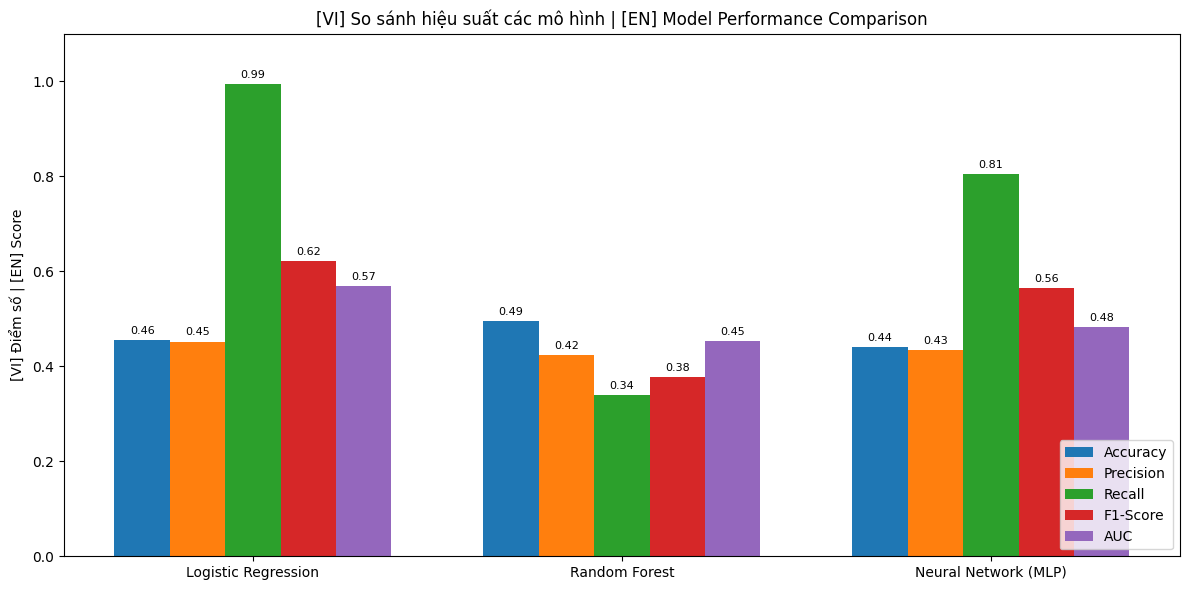

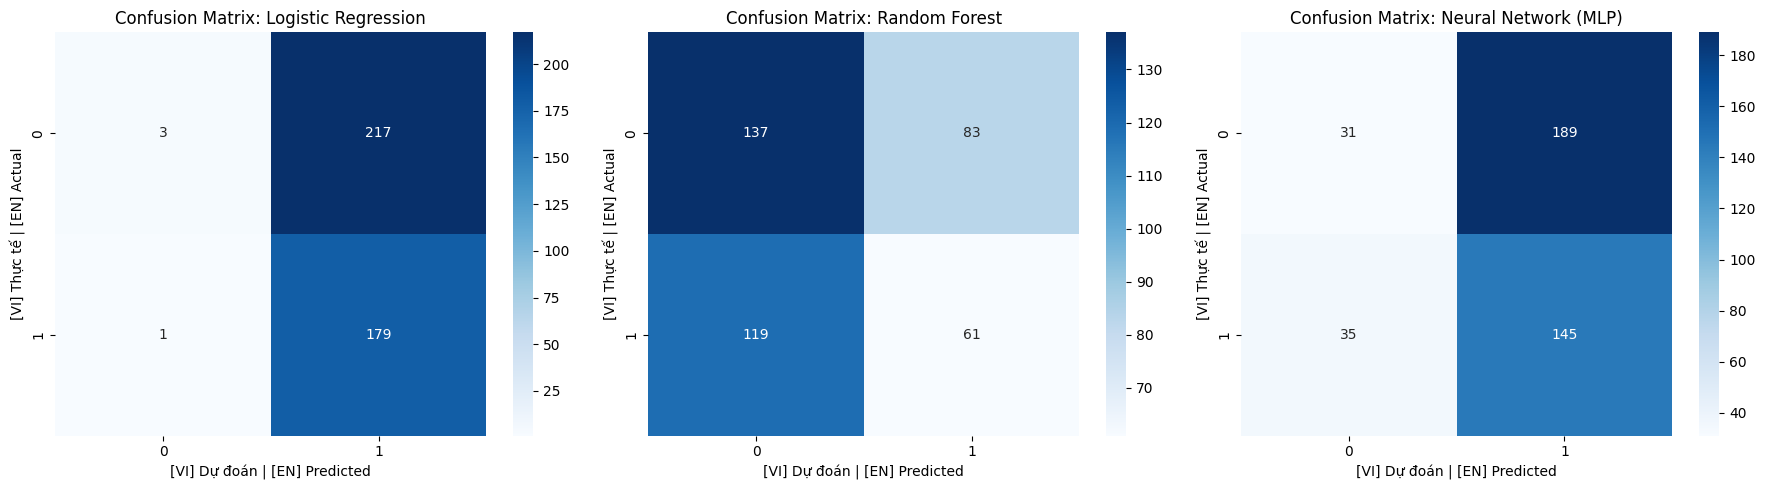

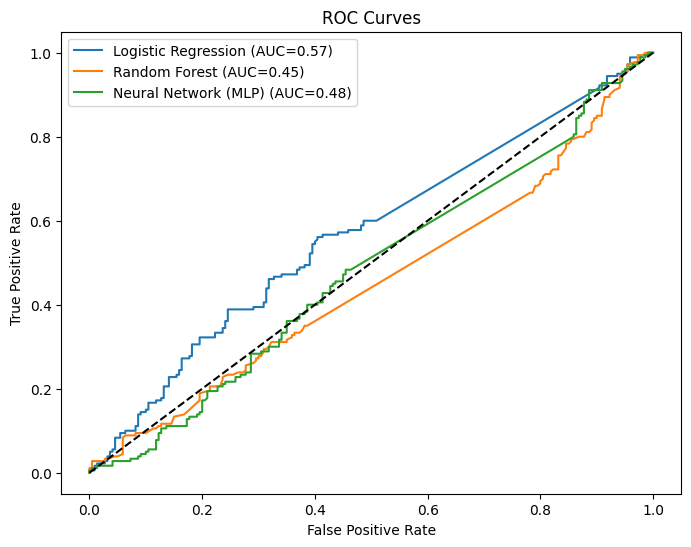


[VI] Mô hình tốt nhất (dựa trên F1-Score) là: Logistic Regression
[EN] The best model (based on F1-Score) is: Logistic Regression


In [15]:
# ============================================
# PART 3 2: TRAINING & INFERENCE PIPELINE (Colab)
# Phần 3: Huấn luyện & suy luận
# ============================================
# [VI] Mô hình embedding, giữ nguyên
# [EN] Embedding model, unchanged
EMBED_MODEL = SentenceTransformer('all-MiniLM-L6-v2')

# ============================================
# Helper functions
# ============================================
def compute_skill_overlap(cv_skills, jd_skills):
    # [VI] Trả về số skill trùng và tỉ lệ trùng
    # [EN] Return matched_count, match_ratio
    set_cv = set([s.lower() for s in cv_skills])
    set_jd = set([s.lower() for s in jd_skills])
    matched = set_cv.intersection(set_jd)
    missing_list = sorted(list(set_jd - set_cv))
    matched_count = len(matched)
    match_ratio = matched_count / (len(set_jd) + 1e-9)
    return matched_count, match_ratio, sorted(list(matched)), sorted(list(set_jd - set_cv))

def tfidf_cosine_similarity(text_a, text_b, vectorizer=None):
    # [VI] TF-IDF cosine similarity
    # [EN] TF-IDF cosine similarity
    if vectorizer is None:
        vectorizer = TfidfVectorizer(lowercase=True)
        X = vectorizer.fit_transform([text_a, text_b])
    else:
        X = vectorizer.transform([text_a, text_b])
    v0 = X[0].toarray()[0]
    v1 = X[1].toarray()[0]
    denom = (np.linalg.norm(v0) * np.linalg.norm(v1) + 1e-9)
    return float(np.dot(v0, v1)/denom), vectorizer

def embedding_similarity(text_a, text_b, model=EMBED_MODEL):
    # [VI] Sentence-transformer cosine similarity
    # [EN] Sentence-transformer cosine similarity
    emb_a = model.encode(text_a, convert_to_tensor=True)
    emb_b = model.encode(text_b, convert_to_tensor=True)
    sim = util.cos_sim(emb_a, emb_b).item()
    return float(sim)

def build_features_single(cv_text, cv_skills, jd_text, jd_skills, vectorizer=None):
    cv_text_str = str(cv_text) if not pd.isna(cv_text) else ""
    jd_text_str = str(jd_text) if not pd.isna(jd_text) else ""
    # [VI] Xây dựng vector đặc trưng cho một cặp CV-JD
    # [EN] Build feature vector for a single CV-JD pair
    num_skills_cv = len(cv_skills)
    num_skills_jd = len(jd_skills)
    matched_count, match_ratio, matched_list, missing_list = compute_skill_overlap(cv_skills, jd_skills)
    tfidf_sim, vectorizer = tfidf_cosine_similarity(" ".join(cv_skills) + " " + cv_text_str,
                                                    " ".join(jd_skills) + " " + jd_text_str,
                                                    vectorizer=vectorizer)
    emb_sim = embedding_similarity(cv_text_str, jd_text_str)
    cv_len_tokens = len(re.findall(r'\w+', cv_text_str))
    jd_len_tokens = len(re.findall(r'\w+', jd_text_str))

    features = {
        "num_skills_cv": num_skills_cv,
        "num_skills_jd": num_skills_jd,
        "matched_count": matched_count,
        "match_ratio": match_ratio,
        "tfidf_sim": tfidf_sim,
        "emb_sim": emb_sim,
        "cv_len_tokens": cv_len_tokens,
        "jd_len_tokens": jd_len_tokens,
    }
    meta = {"matched_list": matched_list, "missing_list": missing_list}
    return features, vectorizer, meta

# ============================================
# [VI] Pipeline chính: HUẤN LUYỆN & ĐÁNH GIÁ
# [EN] Main Pipeline: TRAINING & EVALUATION
# ============================================
def train_and_evaluate_models(X, y, models, test_size=0.4):
    """
    [VI] Huấn luyện và đánh giá nhiều mô hình trên cùng một tập dữ liệu.
    [EN] Train and evaluate multiple models on the same dataset.
    """
    # [VI] Chuẩn hóa dữ liệu trước khi huấn luyện
    # [EN] Standardize the data before training
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # [VI] Giảm chiều dữ liệu bằng PCA (nếu cần)
    # [EN] Reduce data dimensionality with PCA (if needed)
    # PCA giúp mô hình Neural Network hoạt động tốt hơn với ít đặc trưng hơn
    # PCA helps the Neural Network model perform better with fewer features
    if X_scaled.shape[1] > 5: # Chỉ áp dụng PCA nếu có nhiều hơn 5 đặc trưng
        pca = PCA(n_components=0.95) # giữ lại 95% phương sai
        X_pca = pca.fit_transform(X_scaled)
        print(f"[VI] Áp dụng PCA: {X_scaled.shape[1]} -> {X_pca.shape[1]} chiều")
        print(f"[EN] Applied PCA: {X_scaled.shape[1]} -> {X_pca.shape[1]} dimensions")
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=test_size, random_state=42
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=42
        )

    results = {}
    for name, model in models.items():
        print(f"\n[VI] Huấn luyện mô hình: {name}...")
        print(f"[EN] Training model: {name}...")
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # [VI] Đánh giá
            # [EN] Evaluation
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
            auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

            print(f"Accuracy: {accuracy:.4f}")
            print(classification_report(y_test, y_pred))

            results[name] = {
                "model": model,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "fscore": fscore,
                "auc": auc,
                "y_pred": y_pred,
                "y_test": y_test,
                "X_test_transformed": X_test,
                "scaler": scaler,
                "pca": pca if 'pca' in locals() else None
            }
        except Exception as e:
            print(f"[VI] Lỗi khi huấn luyện mô hình {name}: {e}")
            print(f"[EN] Error training model {name}: {e}")

    return results

# ============================================
# VISUALIZATION FUNCTIONS
# [VI] CÁC HÀM TRỰC QUAN HÓA
# ============================================
def visualize_results(results):
    """
    [VI] Trực quan hóa các kết quả đánh giá của các mô hình.
    [EN] Visualize the evaluation results of the models.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
    model_names = list(results.keys())
    scores = {
        "Accuracy": [results[name]["accuracy"] for name in model_names],
        "Precision": [results[name]["precision"] for name in model_names],
        "Recall": [results[name]["recall"] for name in model_names],
        "F1-Score": [results[name]["fscore"] for name in model_names],
        "AUC": [results[name]["auc"] for name in model_names],
    }

    x = np.arange(len(model_names))
    width = 0.15

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (metric, values) in enumerate(scores.items()):
        rects = ax.bar(x + (i - 2) * width, values, width, label=metric)
        autolabel(rects, ax)

    ax.set_ylabel("[VI] Điểm số | [EN] Score")
    ax.set_title("[VI] So sánh hiệu suất các mô hình | [EN] Model Performance Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend(loc='lower right')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

def autolabel(rects, ax):
    """[VI] Ghi số lên đầu các cột | [EN] Attach a text label above each bar."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

def plot_confusion_matrix(y_true, y_pred, title, ax):
    """
    [VI] Vẽ ma trận nhầm lẫn
    [EN] Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("[VI] Dự đoán | [EN] Predicted")
    ax.set_ylabel("[VI] Thực tế | [EN] Actual")

# ============================================
# EXECUTION
# [VI] THỰC THI
# ============================================
# [VI] ...
# [EN] Build df_pairs by the cv_texts have extracted from the previous part
# (Code để tạo df_cv đã có trong phần trước)
# --- Step 1: Load CV dataset ---
df_cv = pd.DataFrame({'cv_text': cv_texts})
df_cv = df_cv.sample(min(1000, len(df_cv)), random_state=42).reset_index(drop=True)
print(df_cv.head(2))

# --- Step 2: Tạo các cặp CV-JD ---
jd_text = JOB_DESCRIPTION_SAMPLE
jd_skills = jd_result["skills"]

pairs = []
for idx, row in df_cv.iterrows():
    cv_text = row['cv_text']
    cv_skills = advanced_text_processing(cv_text)["skills"]
    label = random.choice([0, 1])
    pairs.append({
        "cv_text": cv_text,
        "cv_skills": cv_skills,
        "jd_text": jd_text,
        "jd_skills": jd_skills,
        "label": label
    })

df_pairs = pd.DataFrame(pairs)  # <-- quan trọng, convert sang DataFrame

# [VI] Xây dựng features cho toàn bộ dữ liệu
# [EN] Build features for the entire dataset
feature_rows = []
vectorizer = None
metas = []
for idx, row in df_pairs.iterrows():
    feats, vectorizer, meta = build_features_single(
        row.cv_text,
        row.cv_skills,
        row.jd_text,
        row.jd_skills,
        vectorizer=vectorizer
    )
    feature_rows.append(feats)
    metas.append(meta)

X = pd.DataFrame(feature_rows)
y = df_pairs['label'].values

print("[VI] Bảng features sau khi trích xuất:")
print("[EN] Features table after extraction:")
display(X.head())

# [VI] Định nghĩa các mô hình bạn đã học
# [EN] Define the models you have studied
models_to_test = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42),
}

from sklearn.metrics import roc_curve
def plot_roc_curves(results):
    plt.figure(figsize=(8,6))
    for name, res in results.items():
        model = res['model']
        X_test = res['X_test_transformed']  # đã scale/PCA
        try:
            y_proba = model.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(res['y_test'], y_proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.2f})")
        except:
            continue
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()


# [VI] Huấn luyện và đánh giá
# [EN] Train and evaluate
if 'label' in df_pairs.columns and len(np.unique(y)) > 1:
    evaluation_results = train_and_evaluate_models(X, y, models_to_test)

    # [VI] Trực quan hóa kết quả tổng quát
    # [EN] Visualize overall results
    visualize_results(evaluation_results)

    # [VI] Trực quan hóa chi tiết từng mô hình (ma trận nhầm lẫn)
    # [EN] Visualize detailed results for each model (confusion matrix)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (name, res) in enumerate(evaluation_results.items()):
        plot_confusion_matrix(res['y_test'], res['y_pred'], f"Confusion Matrix: {name}", axes[i])
    plt.tight_layout()
    plt.show()

    # Trực quan hóa ROC curve
    plot_roc_curves(evaluation_results)

    # [VI] Lưu mô hình và scaler tốt nhất
    # [EN] Save the best model and scaler
    best_model_name = max(evaluation_results, key=lambda k: evaluation_results[k]['fscore'])
    best_model = evaluation_results[best_model_name]['model']
    best_scaler = evaluation_results[best_model_name]['scaler']
    best_pca = evaluation_results[best_model_name]['pca']

    # Tạo thư mục trained_model nếu chưa tồn tại
    os.makedirs('trained_model', exist_ok=True)
    model_path = os.path.join('trained_model', 'best_model.pkl')
    scaler_path = os.path.join('trained_model', 'scaler.pkl')
    pca_path = os.path.join('trained_model', 'pca.pkl')

    # Lưu
    joblib.dump(best_model, model_path)
    joblib.dump(best_scaler, scaler_path)
    if best_pca:
        joblib.dump(best_pca, pca_path)

    print(f"\n[VI] Mô hình tốt nhất (dựa trên F1-Score) là: {best_model_name}")
    print(f"[EN] The best model (based on F1-Score) is: {best_model_name}")
else:
    print("[VI] Không đủ dữ liệu nhãn để huấn luyện mô hình.")
    print("[EN] Not enough labeled data to train the models.")



---

**DEMO WITH BEST SAVED MODEL**

---

In [16]:
# ============================================================
# PART 4.2: INFERENCE PIPELINE (Colab)
# Chạy dự đoán CV bằng mô hình đã huấn luyện sẵn
# ============================================================

import os, re, joblib, shutil, docx, pdfplumber
import numpy as np, pandas as pd
import nltk, spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util

# ----------- LOAD MODELS -----------
# SpaCy: NER + Tokenization
nlp = spacy.load("en_core_web_sm")
# Embedding models
EMBED_MODEL = SentenceTransformer('all-MiniLM-L6-v2')
MULTI_EMBED_MODEL = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Download NLTK resources (stopwords, tokenizer)
for pkg in ['punkt', 'stopwords']:
    nltk.download(pkg, quiet=True)


# ============================================================
# TEXT PROCESSING HELPERS | HÀM XỬ LÝ VĂN BẢN
# ============================================================

def clean_text(text):
    """Basic cleaning: lowercase + remove special chars
       Tiền xử lý cơ bản: chữ thường + bỏ ký tự đặc biệt"""
    if pd.isna(text): return ""
    return re.sub(r'[^\w\s]', ' ', str(text).lower())

def advanced_text_processing(text, auto_stopwords=None):
    """Full text pipeline: tokenize, stopword removal, NER, skill extraction
       Pipeline xử lý văn bản: tokenize, loại stopwords, NER, trích xuất kỹ năng"""
    text_clean = clean_text(text)
    tokens = nltk.word_tokenize(text_clean)

    # Stopword filtering
    stop_words = set(stopwords.words('english'))
    if auto_stopwords:
        stop_words |= set(auto_stopwords)
    tokens_filtered = [w for w in tokens if w not in stop_words]

    # NER
    doc = nlp(str(text))
    ner_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Skill extraction
    found_skills = {skill for skill in SKILL_LIST if skill.lower() in text_clean}

    return {"tokens": tokens_filtered, "ner_entities": ner_entities, "skills": sorted(found_skills)}


# ============================================================
# FEATURE ENGINEERING | XÂY DỰNG ĐẶC TRƯNG
# ============================================================

def compute_skill_overlap(cv_skills, jd_skills):
    """Skill overlap between CV and JD | So sánh kỹ năng giữa CV và JD"""
    set_cv, set_jd = {s.lower() for s in cv_skills}, {s.lower() for s in jd_skills}
    matched = set_cv & set_jd
    return len(matched), len(matched) / (len(set_jd) + 1e-9), sorted(matched), sorted(set_jd - set_cv)

def tfidf_cosine_similarity(text_a, text_b, vectorizer=None):
    """TF-IDF cosine similarity | Đo độ tương đồng TF-IDF"""
    if not text_a.strip() or not text_b.strip():
        return 0.0, vectorizer  # nếu text rỗng thì similarity = 0

    if vectorizer is None:
        vectorizer = TfidfVectorizer(lowercase=True)
        X = vectorizer.fit_transform([text_a, text_b])
    else:
        X = vectorizer.transform([text_a, text_b])
    v0, v1 = X[0].toarray()[0], X[1].toarray()[0]
    return float(np.dot(v0, v1) / (np.linalg.norm(v0) * np.linalg.norm(v1) + 1e-9)), vectorizer

def embedding_similarity(text_a, text_b, model=EMBED_MODEL):
    """Embedding similarity using sentence-transformers | Tương đồng embedding"""
    emb_a, emb_b = model.encode(text_a, convert_to_tensor=True), model.encode(text_b, convert_to_tensor=True)
    return float(util.cos_sim(emb_a, emb_b).item())

def build_features_single(cv_text, cv_skills, jd_text, jd_skills, vectorizer=None):
    """Create feature vector for CV-JD pair | Tạo vector đặc trưng cho cặp CV-JD"""
    cv_str, jd_str = str(cv_text or ""), str(jd_text or "")

    # Skills overlap
    matched_count, match_ratio, matched_list, missing_list = compute_skill_overlap(cv_skills, jd_skills)

    # Text similarities
    tfidf_sim, vectorizer = tfidf_cosine_similarity(" ".join(cv_skills) + " " + cv_str,
                                                    " ".join(jd_skills) + " " + jd_str,
                                                    vectorizer=vectorizer)
    emb_sim = embedding_similarity(cv_str, jd_str)

    features = {
        "num_skills_cv": len(cv_skills),
        "num_skills_jd": len(jd_skills),
        "matched_count": matched_count,
        "match_ratio": match_ratio,
        "tfidf_sim": tfidf_sim,
        "emb_sim": emb_sim,
        "cv_len_tokens": len(re.findall(r'\w+', cv_str)),
        "jd_len_tokens": len(re.findall(r'\w+', jd_str))
    }
    return features, vectorizer, {"matched_list": matched_list, "missing_list": missing_list}


# ============================================================
# MODEL LOADING | TẢI MÔ HÌNH
# ============================================================

def load_trained_model(trained_model_dir="trained_model"):
    """Load trained model, scaler, PCA | Tải mô hình, scaler, PCA đã train"""
    model = joblib.load(os.path.join(trained_model_dir, "best_model.pkl"))
    scaler = joblib.load(os.path.join(trained_model_dir, "scaler.pkl"))
    pca_path = os.path.join(trained_model_dir, "pca.pkl")
    pca = joblib.load(pca_path) if os.path.exists(pca_path) else None
    return model, scaler, pca


# ============================================================
# INFERENCE | DỰ ĐOÁN
# ============================================================

def predict_cv_dataframe(df_cv, jd_text, jd_skills, trained_model_dir="trained_model"):
    """Predict CV-JD fit from dataframe | Dự đoán CV có phù hợp JD không"""
    auto_stopwords = get_auto_stopwords_from_dataset(df_cv.iloc[:, 0].astype(str).tolist(), top_n=20)
    model, scaler, pca = load_trained_model(trained_model_dir)
    vectorizer, results = None, []

    for _, row in df_cv.iterrows():
        cv_text = row['Resume_str']
        cv_skills = advanced_text_processing(cv_text, auto_stopwords)["skills"]

        feats, vectorizer, _ = build_features_single(cv_text, cv_skills, jd_text, jd_skills, vectorizer)
        X_scaled = scaler.transform(pd.DataFrame([feats]))
        if pca: X_scaled = pca.transform(X_scaled)

        pred_label = model.predict(X_scaled)[0]
        pred_proba = model.predict_proba(X_scaled)[0, 1] if hasattr(model, "predict_proba") else None

        results.append({"cv_text": cv_text, "pred_label": pred_label, "pred_proba": pred_proba, "extracted_skills": cv_skills})

    return pd.DataFrame(results)


# ============================================================
# FILE HANDLER | XỬ LÝ FILE CV
# ============================================================

def read_cv_file(file_path):
    """Read CV file (.pdf, .docx, .txt) → text | Đọc CV từ file sang text"""
    ext = os.path.splitext(file_path)[-1].lower()
    text = ""
    if ext == ".pdf":
        with pdfplumber.open(file_path) as pdf:
            text = "\n".join([p.extract_text() or "" for p in pdf.pages])
    elif ext == ".docx":
        text = "\n".join([para.text for para in docx.Document(file_path).paragraphs])
    elif ext == ".txt":
        with open(file_path, "r", encoding="utf-8") as f: text = f.read()
    else:
        raise ValueError("Unsupported file format | Định dạng file không hỗ trợ")
    return text.strip()


# ============================================================
# QUESTION SUGGESTION | GỢI Ý CÂU HỎI
# ============================================================

def print_matched_questions(cv_embedding, question_embeddings, questions_df, threshold=0.25, top_k=10):
    """Suggest most relevant questions from CV | Gợi ý câu hỏi phù hợp từ CV"""
    results, seen = util.semantic_search(cv_embedding, question_embeddings, top_k=top_k)[0], set()

    for r in results:
        if r['score'] < threshold: continue
        q_row = questions_df.iloc[r['corpus_id']]
        question_col = "question" if "question" in q_row else "Question"
        q_text = q_row[question_col]

        if q_text in seen: continue
        seen.add(q_text)

        print(f"Score: {r['score']:.3f}\nQuestion: {q_text}")
        if "category" in q_row or "Category" in q_row:
            print(f"Category: {q_row.get('category', q_row.get('Category'))}")
        if "role" in q_row: print(f"Role: {q_row['role']}")
        if "experience" in q_row: print(f"Experience: {q_row['experience']}")
        if "difficulty" in q_row or "Difficulty" in q_row:
            print(f"Difficulty: {q_row.get('difficulty', q_row.get('Difficulty'))}")
        if "Answer" in q_row: print(f"Answer: {q_row['Answer']}")
        print("-" * 60)


# ============================================================
# EXECUTION (UPLOAD + PREDICTION) | THỰC THI (UPLOAD + DỰ ĐOÁN)
# ============================================================

from google.colab import files  # Only for Colab | Chỉ dùng trên Colab

# Upload CV
os.makedirs("uploaded_cv", exist_ok=True)
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
file_path = os.path.join("uploaded_cv", file_name)
shutil.move(file_name, file_path)

# Read file → DataFrame
cv_text = read_cv_file(file_path)
df_cv = pd.DataFrame({"Resume_str": [cv_text]})

# Predict
df_results = predict_cv_dataframe(df_cv, JOB_DESCRIPTION_SAMPLE, jd_result["skills"])

valid_cvs = df_results[df_results['pred_label'] == 1]
if valid_cvs.empty: print("CV is not suitable | CV không phù hợp.")

for _, row in valid_cvs.iterrows():
    print("\nSkills in JD:", jd_result["skills"])
    print("Skills in CV:", row['extracted_skills'])

    # Encode CV + Questions
    sw_q_df = pd.read_csv("./data/software_questions.csv", encoding="windows-1252")
    sw_embeddings = MULTI_EMBED_MODEL.encode(sw_q_df['Question'].astype(str).tolist(), convert_to_tensor=True)
    cv_embedding = EMBED_MODEL.encode([row['cv_text']], convert_to_tensor=True)

    print("=== Suggested Software Questions ===")
    print_matched_questions(cv_embedding, sw_embeddings, sw_q_df, threshold=0.15, top_k=5)


Saving BE-AI CV.pdf to BE-AI CV.pdf

Skills in JD: ['android', 'aws', 'azure', 'database', 'git', 'go', 'ios', 'java', 'mongodb', 'mysql', 'sql', 'swift', 'version control']
Skills in CV: ['algorithms', 'css', 'database', 'deep learning', 'git', 'go', 'html', 'java', 'javascript', 'machine learning', 'mysql', 'php', 'postgresql', 'problem solving', 'python', 'sql']
=== Suggested Software Questions ===
Score: 0.240
Question: Design a cloud-based virtual desktop infrastructure.
Category: System Design
Difficulty: Hard
Answer: Address virtualization technologies, resource allocation, security, and remote access protocols.
------------------------------------------------------------
Score: 0.233
Question: Discuss the advantages and disadvantages of using an ORM tool.
Category: Database and SQL
Difficulty: Medium
Answer: ORM simplifies database interactions and is language-agnostic. It can introduce performance overhead and may limit database features.
--------------------------------------